In [201]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.autograd import Variable
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

In [202]:
train = pd.read_parquet("train.parquet")
train.head()

,feature0,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,...,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,target0,target1
0,32.910908,17.376350,77.557840,2.929855,gas1,20.487150,57.633085,49.245392,-44.124381,23.400064,...,14.203652,9.689942,17.951627,24.198589,102.448710,110.529868,56.817260,12.887802,27.050891,6.502743
1,41.263782,22.419445,47.945514,-25.847472,gas2,21.461239,3.474080,49.659980,-13.553188,-13.047593,...,-14.451904,-0.906120,105.724742,-9.435222,-16.060150,37.286110,61.224272,39.822424,84.127890,76.578716
2,25.580283,17.376350,77.654180,2.799411,gas1,20.487150,28.938295,49.245392,-44.124381,20.610679,...,14.395054,9.779019,17.951638,24.999453,101.728213,111.471534,52.664304,12.887802,22.080133,3.036043
3,33.756900,17.376350,73.049625,2.953982,gas1,20.487150,28.932311,49.245392,-44.124381,18.107963,...,14.184314,9.798969,17.951675,23.990300,101.312113,115.589451,56.840719,12.887802,30.234082,8.910795
4,4.223732,38.772534,48.015553,-25.843943,gas2,24.635721,12.011581,51.030938,84.244199,-17.735680,...,-14.439953,8.262354,90.187207,-2.901661,-16.060150,37.398779,40.488468,128.295838,71.128092,50.475082


In [203]:
n_gas = 2

In [204]:
df1 = train[train.feature4 == f'gas{n_gas}']

In [205]:
columns_for_predict = ['target0', 'target1']

### feature engenering

In [206]:
features = ['feature0',
 'feature1',
 'feature2',
 'feature3',
 'feature5',
 'feature6',
 'feature7',
 'feature8',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature20',
 'feature22']

In [207]:
# features = ['feature0',
#  'feature1',
#  'feature11',
#  'feature13',
#  'feature14',
#  'feature16',
#  'feature20',
#  'feature6',
#  'feature9']

In [208]:
df = df1[df1['feature8'] > -30]

In [209]:
X = df1[features]
y = df1[columns_for_predict]

In [210]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=41)

In [211]:
### normilize data

# Scaler_x_train = StandardScaler()
# Scaler_x_test = StandardScaler()
# Scaler_y_train = StandardScaler()
# Scaler_y_test = StandardScaler()


# X_train = Scaler_x_train.fit_transform(X_train)
# y_train  = Scaler_y_train.fit_transform(y_train)

# X_test = Scaler_x_test.fit_transform(X_test)
# y_test  = Scaler_y_test.fit_transform(y_test)

In [212]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [213]:
class Net(nn.Module):
    def __init__(self, input_size=24):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc21 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = F.sigmoid(self.fc21(x))
        x = self.fc3(x)
        return x


In [214]:
def train(model, X_train, y_train, X_test, y_test, optimizer, criterion, batch_size, n_epochs):
    """
    Для обучения нейронной сети
    :param model:
    :param X_train:
    :param y_train:
    :param X_test:
    :param y_test:
    :param optimizer:
    :param criterion:
    :param batch_size:
    :param n_epochs:
    :return:
    """
    batch_no = len(X_train) // batch_size

    train_loss = 0
    # train_loss_min = np.Inf

    loss_values_train = []
    loss_values_test = []
    for epoch in range(n_epochs):
        for i in range(batch_no):
            start = i * batch_size
            end = start + batch_size
            x_var = torch.FloatTensor(X_train[start:end])
            y_var = torch.FloatTensor(y_train[start:end])

            optimizer.zero_grad()  # обнулить все градиенты
            output = model(x_var)
            loss = criterion(output, y_var)
            loss.backward()  # считаем градиент
            optimizer.step()  # вызываем пошаговую функцию оптимизатора, который обновляет свои параметры.

            train_loss += loss.item() * batch_size

        train_loss = train_loss / len(X_train)

        if epoch % 200 == 0:
            print('')
            print("Epoch: {} \tTrain Loss: {}".format(epoch + 1, train_loss))

        # test
        x_test_var = torch.FloatTensor(X_test)
        y_test_var = torch.FloatTensor(y_test)
        output = model(x_test_var)
        test_loss = criterion(output, y_test_var)
        test_loss = test_loss.item()

        loss_values_test.append(test_loss)
        loss_values_train.append(train_loss)
    return model, loss_values_train, loss_values_test

In [215]:
batch_size = 128
n_epochs = 300
model = Net(input_size=X_test.shape[1])

In [216]:
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

In [217]:
model,loss_values_train, loss_values_test = train(model, X_train, y_train, X_test, y_test, optimizer, criterion, batch_size, n_epochs)



Epoch: 1 	Train Loss: 234.57689098629328

Epoch: 201 	Train Loss: 0.9100755741164194


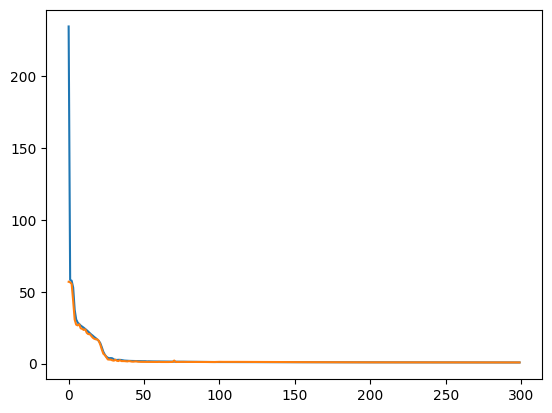

In [219]:
plt.plot(loss_values_train)
plt.plot(loss_values_test)
# plt.ylim((0,0.1))

#### test

In [220]:
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False) 
with torch.no_grad():
    test_result = model(X_test_var)

In [221]:
# # inverse the y_test data back to 1,2,3,4
# y_new_inverse = Scaler_y_test.inverse_transform(y_test)
# y_pred_inverse = Scaler_y_test.inverse_transform(test_result)

# mean_absolute_percentage_error(y_new_inverse, y_pred_inverse)

In [222]:
mean_absolute_percentage_error(y_test, test_result)

0.012387738269744706

gas 2: 0.01196633358862598

gas 1: 0.02328757962759617


с нормализацией:

gas 1: 0.04109559396261545

gas 2: 0.01588126440058686


с логарифмом:

gas 1: 0.041498254378973407


In [223]:
path = f'nn_gas{n_gas}_part1.pt'

In [224]:
torch.save(model.state_dict(), path)

In [225]:
test_result

tensor([[84.1648, 72.6487],
        [90.2054, 53.4967],
        [86.9093, 44.7761],
        ...,
        [75.7548, 35.0466],
        [78.7135, 35.2260],
        [75.1511, 45.2514]])

# model 2

In [245]:
features = ['feature0',
 'feature1',
 'feature2',
 'feature3',
 'feature5',
 'feature6',
 'feature7',
 'feature9',
 'feature10',
 'feature11',
 'feature12',
 'feature13',
 'feature14',
 'feature15',
 'feature16',
 'feature17',
 'feature18',
 'feature20',
 'feature22']

In [246]:
class Net2(nn.Module):
    def __init__(self, input_size=24):
        super(Net2, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)
        
    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
        x = F.sigmoid(self.fc2(x))
        x = self.fc3(x)
        return x

In [247]:
df = df1[df1['feature8'] < -30]

In [248]:
X = df[features]
y = df[columns_for_predict]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=41)

In [249]:
X_train = X_train.values
y_train = y_train.values

X_test = X_test.values
y_test = y_test.values

In [250]:
batch_size = 128
n_epochs = 400
model = Net2(input_size=X_test.shape[1])

optimizer = torch.optim.SGD(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

model,loss_values_train, loss_values_test = train(model, X_train, y_train, X_test, 
                                                  y_test, optimizer, criterion, batch_size, n_epochs)


Epoch: 1 	Train Loss: 1601.7410896523998

Epoch: 201 	Train Loss: 3.0271541624456297


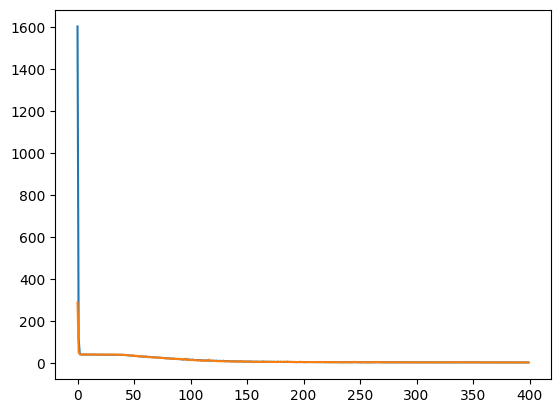

In [251]:
plt.plot(loss_values_train)
plt.plot(loss_values_test)
# plt.ylim((0,0.1))

In [252]:
X_test_var = Variable(torch.FloatTensor(X_test), requires_grad=False) 
with torch.no_grad():
    test_result = model(X_test_var)

In [253]:
mean_absolute_percentage_error(y_test, test_result)

0.01705721812709588

In [254]:
path = f'nn_gas{n_gas}_part2.pt'

In [255]:
torch.save(model.state_dict(), path)